# Preprocess files

In [1]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt

In [2]:
# load train test and valid files
def load_files(path, all_channel_names, test_files, target_file):  
    print("Loading testing files...")
        
    data_size = [
        os.path.getsize(f"{path}{file}") 
        for file in test_files
    ]
    print(f"Total size of data that will be loaded in RAM: {sum(data_size) * 1e-9:.2f}GB\n")
    
    print("Loading numpy arrays...")
    X_test_scaled = np.stack([np.load(f"{path}{file}") for file in test_files], axis=-1)
    Y_test = np.load(f"{path}{target_file}")
    print("Data successfully loaded.")
    
    return X_test_scaled, Y_test

all_channel_names = ['MAIAC_AOD', 'TROPOMI_NO2', 'METAR_Wind_U', 'METAR_Wind_V', 'METAR_Wind_Speed', 'AirNow_PM25', 'HRRR_COLMD']
test_files = [
    "MAIAC_AOD_X_test.npy", "TROPOMI_NO2_X_test.npy", 
    "METAR_Wind_U_X_test.npy", "METAR_Wind_V_X_test.npy", "METAR_Wind_Speed_X_test.npy", 
    "AirNow_PM25_X_test.npy", "HRRR_COLMD_X_test.npy"
]
target_file = "Y_test.npy"
path = 'final_input_data/two_years_with_hrrr/'
X_test_scaled, Y_test = load_files(path, all_channel_names, test_files, target_file)

Loading testing files...
Total size of data that will be loaded in RAM: 1.18GB

Loading numpy arrays...
Data successfully loaded.


In [3]:
def reshape_target(Y_test):
    s, f, st = Y_test.shape
    return Y_test.reshape(s, f*st)
    
def reshape_features(X_test_scaled):
    samples, f, h, w, c = X_test_scaled.shape
    return X_test_scaled.reshape((samples, f*h*w, c))
    
X_reshaped = reshape_features(X_test_scaled)
Y_reshaped = reshape_target(Y_test)
X_reshaped.shape, Y_reshaped.shape

((2631, 8000, 7), (2631, 40))

In [4]:
def to_df(X_reshaped, Y_reshaped, all_channel_names):
    dfs = [pd.DataFrame(X_reshaped[:,:,ch]).mean(axis=1) for ch in range(X_reshaped.shape[-1])]
    df = pd.concat(dfs, axis=1)
    df.columns = all_channel_names
    df['AirNow_PM25_Future'] = pd.DataFrame(np.mean(Y_reshaped, axis=-1))
    return df
    
df = to_df(X_reshaped, Y_reshaped, all_channel_names)
df

,MAIAC_AOD,TROPOMI_NO2,METAR_Wind_U,METAR_Wind_V,METAR_Wind_Speed,AirNow_PM25,HRRR_COLMD,AirNow_PM25_Future
0,0.329745,-0.261879,1.370853,1.047072,0.994136,-0.177864,-0.010060,9.2975
1,0.329745,-0.261879,1.173626,0.759049,0.754557,-0.178996,-0.010063,9.6325
2,0.329745,-0.261879,0.909846,0.612674,0.500403,-0.162879,-0.010066,9.8000
3,0.329745,-0.261879,0.664713,0.388388,0.211931,-0.139824,-0.010067,9.8100
4,0.329745,-0.261879,0.408724,0.175466,-0.004378,-0.087051,-0.010070,9.8025
...,...,...,...,...,...,...,...,...
2626,0.029505,0.525400,-0.516552,-1.346846,-0.236552,-0.453734,-0.010155,3.8400
2627,0.029505,0.525400,-0.478427,-1.276977,-0.213648,-0.542944,-0.010155,3.2775
2628,0.029505,0.525400,-0.489023,-1.322029,-0.240480,-0.582811,-0.010155,2.6825
2629,0.029505,0.525400,-0.507124,-1.266380,-0.195399,-0.649865,-0.010155,2.3175


# Pairplots for test data 
(last 4-ish months of 2024)

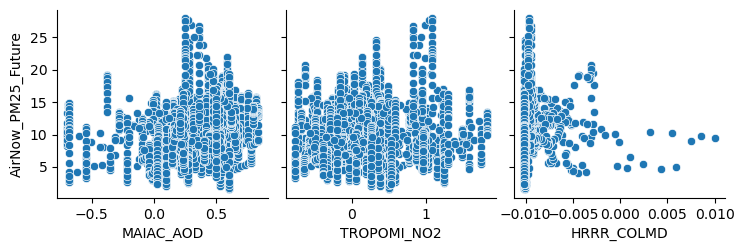

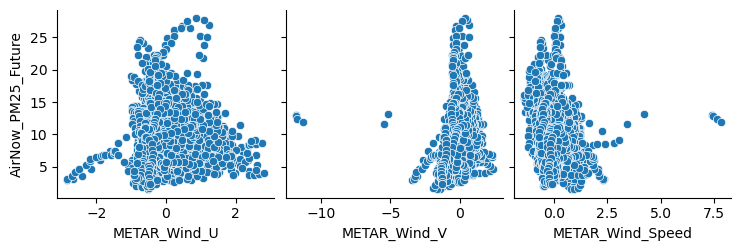

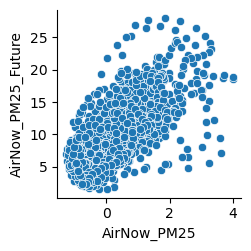

In [5]:
sns.pairplot(df, y_vars=['AirNow_PM25_Future'], x_vars = ['MAIAC_AOD', 'TROPOMI_NO2', 'HRRR_COLMD'])
sns.pairplot(df, y_vars=['AirNow_PM25_Future'], x_vars = ['METAR_Wind_U', 'METAR_Wind_V', 'METAR_Wind_Speed'])
sns.pairplot(df, y_vars=['AirNow_PM25_Future'], x_vars = ['AirNow_PM25'])

In [6]:
def trim(df):
    z_scores = df.apply(zscore)
    return df[(np.abs(z_scores) < 3).all(axis=1)]
    
df_clean = trim(df)
df_clean

,MAIAC_AOD,TROPOMI_NO2,METAR_Wind_U,METAR_Wind_V,METAR_Wind_Speed,AirNow_PM25,HRRR_COLMD,AirNow_PM25_Future
0,0.329745,-0.261879,1.370853,1.047072,0.994136,-0.177864,-0.010060,9.2975
1,0.329745,-0.261879,1.173626,0.759049,0.754557,-0.178996,-0.010063,9.6325
2,0.329745,-0.261879,0.909846,0.612674,0.500403,-0.162879,-0.010066,9.8000
3,0.329745,-0.261879,0.664713,0.388388,0.211931,-0.139824,-0.010067,9.8100
4,0.329745,-0.261879,0.408724,0.175466,-0.004378,-0.087051,-0.010070,9.8025
...,...,...,...,...,...,...,...,...
2626,0.029505,0.525400,-0.516552,-1.346846,-0.236552,-0.453734,-0.010155,3.8400
2627,0.029505,0.525400,-0.478427,-1.276977,-0.213648,-0.542944,-0.010155,3.2775
2628,0.029505,0.525400,-0.489023,-1.322029,-0.240480,-0.582811,-0.010155,2.6825
2629,0.029505,0.525400,-0.507124,-1.266380,-0.195399,-0.649865,-0.010155,2.3175


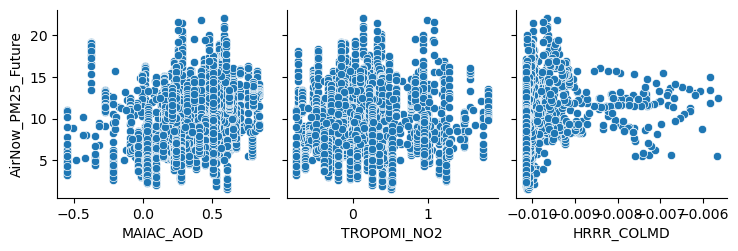

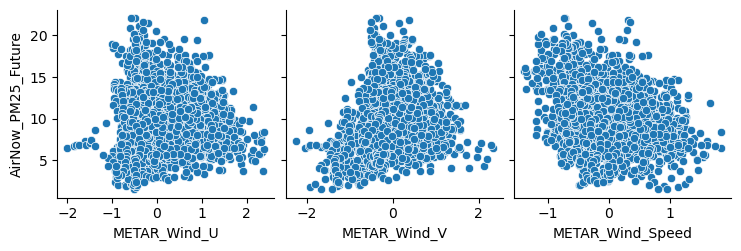

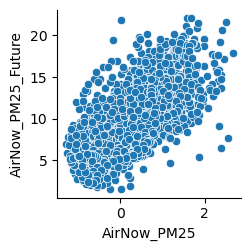

In [7]:
sns.pairplot(df_clean, y_vars=['AirNow_PM25_Future'], x_vars = ['MAIAC_AOD', 'TROPOMI_NO2', 'HRRR_COLMD'])
sns.pairplot(df_clean, y_vars=['AirNow_PM25_Future'], x_vars = ['METAR_Wind_U', 'METAR_Wind_V', 'METAR_Wind_Speed'])
sns.pairplot(df_clean, y_vars=['AirNow_PM25_Future'], x_vars = ['AirNow_PM25'])

Average of past 5 frames vs Average PM2.5 of next 5 frames. 
- Seems like the only real correlation here is that no wind = more PM2.5, as high values of PM2.5 seem to exclusive concentrate at 0 wind. Interested in a wind speed only channel.
- Obviously, past average PM2.5 correlates with future PM2.5.
- COLMD only really works under fire conditions, so I don't expect it to do well. Could test during fire scenario to see if a better correlation is drawn
- NO2 seems to have weak correlation.
- MAIAC might have a positive correlation.

**Added wind speed**, looks to be a strong negative correlation.

# Pairplots for Jan data

In [8]:
X, y = load_files(
    path='final_input_data/jan_2025_with_hrrr/',
    all_channel_names=all_channel_names,
    test_files=[
        "MAIAC_AOD_X_jan_test.npy", "TROPOMI_NO2_X_jan_test.npy", "METAR_Wind_U_X_jan_test.npy", 
        "METAR_Wind_V_X_jan_test.npy", "AirNow_PM25_X_jan_test.npy", "HRRR_COLMD_X_jan_test.npy"
    ],
    target_file='Y_jan_test.npy'
)
print(X.shape, y.shape)

X_reshaped, y_reshaped = reshape_features(X), reshape_target(y)
print(X_reshaped.shape, y_reshaped.shape)

df = to_df(X_reshaped, Y_reshaped, ['MAIAC_AOD', 'TROPOMI_NO2', 'METAR_Wind_U', 'METAR_Wind_V', 'AirNow_PM25', 'HRRR_COLMD'])
display(df)

df_clean = trim(df)
display(df_clean)

Loading testing files...
Total size of data that will be loaded in RAM: 0.28GB

Loading numpy arrays...
Data successfully loaded.
(735, 5, 40, 40, 6) (735, 5, 8)
(735, 8000, 6) (735, 40)


,MAIAC_AOD,TROPOMI_NO2,METAR_Wind_U,METAR_Wind_V,AirNow_PM25,HRRR_COLMD,AirNow_PM25_Future
0,-0.111595,0.583410,0.187964,0.002928,4.395915,-0.010156,9.2975
1,-0.111595,0.583410,-0.084622,-0.107465,4.847988,-0.010156,9.6325
2,-0.111595,0.583410,-0.303903,-0.214141,5.260480,-0.010156,9.8000
3,-0.111595,0.583410,-0.445264,-0.370347,5.629600,-0.010156,9.8100
4,-0.111595,0.583410,-0.476031,-0.495491,6.240325,-0.010156,9.8025
...,...,...,...,...,...,...,...
730,-0.158758,-0.066775,-0.642954,-0.616691,1.105650,-0.010022,9.8725
731,-0.158758,-0.066775,-0.661279,-0.616997,1.032004,-0.010018,10.5450
732,-0.158758,-0.066775,-0.633732,-0.623378,1.060689,-0.010009,11.0250
733,-0.158758,-0.066775,-0.598034,-0.541543,1.115201,-0.010011,11.5150


,MAIAC_AOD,TROPOMI_NO2,METAR_Wind_U,METAR_Wind_V,AirNow_PM25,HRRR_COLMD,AirNow_PM25_Future
0,-0.111595,0.583410,0.187964,0.002928,4.395915,-0.010156,9.2975
1,-0.111595,0.583410,-0.084622,-0.107465,4.847988,-0.010156,9.6325
2,-0.111595,0.583410,-0.303903,-0.214141,5.260480,-0.010156,9.8000
3,-0.111595,0.583410,-0.445264,-0.370347,5.629600,-0.010156,9.8100
13,-0.111595,0.583410,-0.645171,-0.534510,5.855338,-0.010154,11.2125
...,...,...,...,...,...,...,...
730,-0.158758,-0.066775,-0.642954,-0.616691,1.105650,-0.010022,9.8725
731,-0.158758,-0.066775,-0.661279,-0.616997,1.032004,-0.010018,10.5450
732,-0.158758,-0.066775,-0.633732,-0.623378,1.060689,-0.010009,11.0250
733,-0.158758,-0.066775,-0.598034,-0.541543,1.115201,-0.010011,11.5150


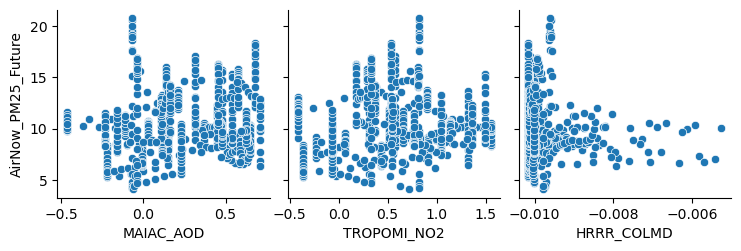

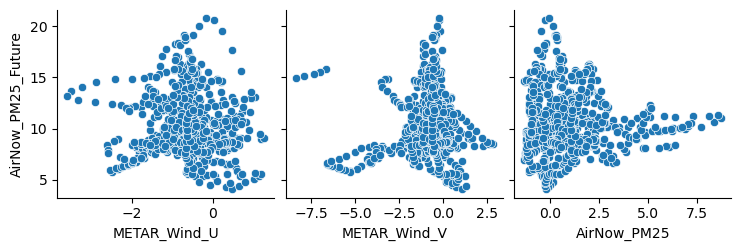

In [9]:
sns.pairplot(df, y_vars=['AirNow_PM25_Future'], x_vars = ['MAIAC_AOD', 'TROPOMI_NO2', 'HRRR_COLMD'])
sns.pairplot(df, y_vars=['AirNow_PM25_Future'], x_vars = ['METAR_Wind_U', 'METAR_Wind_V', 'AirNow_PM25'])

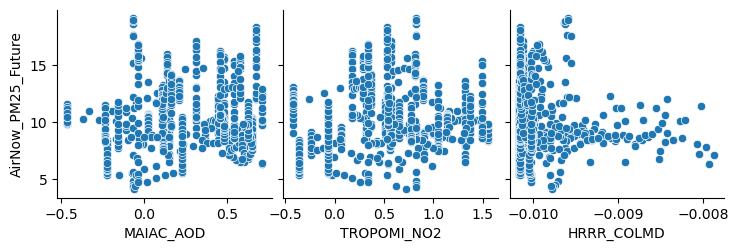

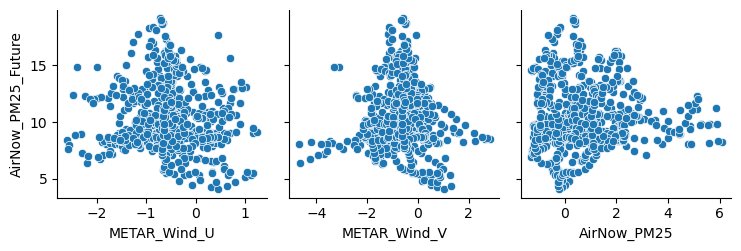

In [10]:
sns.pairplot(df_clean, y_vars=['AirNow_PM25_Future'], x_vars = ['MAIAC_AOD', 'TROPOMI_NO2', 'HRRR_COLMD'])
sns.pairplot(df_clean, y_vars=['AirNow_PM25_Future'], x_vars = ['METAR_Wind_U', 'METAR_Wind_V', 'AirNow_PM25'])

As expected, a parabolic curve for wind implies strong winds = less PM2.5, no wind = higher PM2.5. PM2.5. stays low, then as time goes on with no wind, it begins to accumulate.

Though it seems for this set, previous PM2.5 doesn't correlate as strongly to next frame's PM2.5; seems to be more dramatic of an increase, with exceptions for this band of 5-10 PM2.5. My guess is during the fire, PM2.5 increased dramatically frame to frame; but days with no fire affect the set here as well, because it's quite linear there.

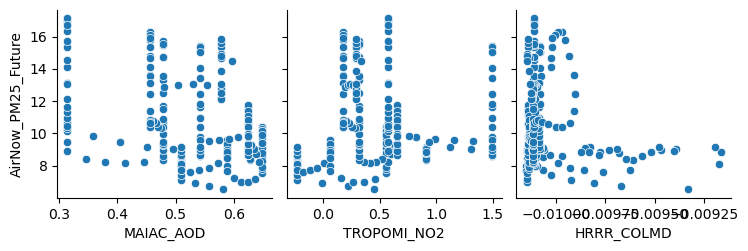

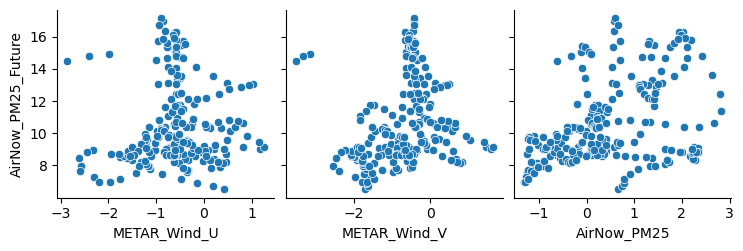

In [11]:
# roughly jan 10th - 20th
sns.pairplot(trim(df[240:480]), y_vars=['AirNow_PM25_Future'], x_vars = ['MAIAC_AOD', 'TROPOMI_NO2', 'HRRR_COLMD'])
sns.pairplot(trim(df[240:480]), y_vars=['AirNow_PM25_Future'], x_vars = ['METAR_Wind_U', 'METAR_Wind_V', 'AirNow_PM25'])

Even directly on a fire event, there doesn't seem to be a strong correlation between average smoke and average pm2.5. This may be because COLMD is a measure of smoke in the entire vertical column, as opposed to MASSDEN, which is a direct forecast of PM2.5 from smoke 8m above ground.

My guess is that even though smoke is accumulating, it's doing so in the upper atmosphere, not affecting PM2.5 sensors. So in the specific case of predicting just PM2.5, MASSDEN may be the better product.